### Cold Start Problem

In the previous notebook, you learned about the **Cold Start Problem** first hand. In cases where you are introduced to a new user or new movie, collaborative flitering is not helpful as a technique to make predictions.

Instead, you will need to use one of the techniques from the previous lesson like content based recommendations for new items **(movie)** or rank based recommendations for new users.  

As a final step to completing out our recommendation system, we will build in these edge cases. Run the cell below to get started.

### Matrix Factorization - Collaborative Filtering Where Possible

Notice the following information is available by running the below cell:

`1.` **reviews** - a dataframe of reviews

`2.` **movies** - a dataframe of movies

`3.` **create_train_test** - a function for creating the training and validation datasets

`4.` **predict_rating** - a function that takes a user and movie and gives a prediction using FunkSVD

`5.` **train_df** and **val_df** - the training and test datasets used in the previous notebook

`6.` **user_mat** and **movie_mat** - the u and v matrices from FunkSVD

`7.` **train_data_df** - a user-movie matrix with ratings where available.  FunkSVD was performed on this matrix

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
!pip install progressbar
import progressbar

# Read in the datasets
movies = pd.read_csv('data/movies_clean.csv')
reviews = pd.read_csv('data/reviews_clean.csv')

del movies['Unnamed: 0']
del reviews['Unnamed: 0']

def create_train_test(reviews, order_by, training_size, testing_size):
    '''    
    INPUT:
    reviews - (pandas df) dataframe to split into train and test
    order_by - (string) column name to sort by
    training_size - (int) number of rows in training set
    testing_size - (int) number of columns in the test set
    
    OUTPUT:
    training_df -  (pandas df) dataframe of the training set
    validation_df - (pandas df) dataframe of the test set
    '''
    reviews_new = reviews.sort_values(order_by)
    training_df = reviews_new.head(training_size)
    validation_df = reviews_new.iloc[training_size:training_size+testing_size]
    
    return training_df, validation_df

def predict_rating(user_matrix, movie_matrix, user_id, movie_id):
    '''
    INPUT:
    user_matrix - user by latent factor matrix
    movie_matrix - latent factor by movie matrix
    user_id - the user_id from the reviews df
    movie_id - the movie_id according the movies df
    
    OUTPUT:
    pred - the predicted rating for user_id-movie_id according to FunkSVD
    '''
    # Create series of users and movies in the right order
    user_ids_series = np.array(train_data_df.index)
    movie_ids_series = np.array(train_data_df.columns)
    
    # User row and Movie Column
    user_row = np.where(user_ids_series == user_id)[0][0]
    movie_col = np.where(movie_ids_series == movie_id)[0][0]
    
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(user_matrix[user_row, :], movie_matrix[:, movie_col])
    
    return pred

# Use our function to create training and test datasets
train_df, val_df = create_train_test(reviews, 'date', 8000, 2000)

# Create user-by-item matrix - this will keep track of order of users and movies in u and v
train_user_item = train_df[['user_id', 'movie_id', 'rating', 'timestamp']]
train_data_df = train_user_item.groupby(['user_id', 'movie_id'])['rating'].max().unstack()
train_data_np = np.array(train_data_df)

# Read in user and movie matrices
user_file = open("user_matrix", 'rb')   # read trained matrix user*latent space
user_mat = pickle.load(user_file)
user_file.close()

movie_file = open("movie_matrix", 'rb')   # read trained matrix latent space * movie
movie_mat = pickle.load(movie_file)
movie_file.close()

smart-open 1.6.0 requires bz2file, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Validating Predictions

Unfortunately, you weren't able to make predictions on every user-movie combination in the test set, as some of these users or movies were new.  

However, you can validate your predictions for the user-movie pairs that do exist in the user_mat and movie_mat matrices.  

`1.` Complete the function below to see how far off we were on average across all of the predicted ratings.

In [2]:
np.round(2.6)

3.0

In [3]:
x = np.zeros((2,2))

In [4]:
x[0,1] = 1
x

array([[0., 1.],
       [0., 0.]])

In [5]:
def validation_comparison(val_df, user_mat=user_mat, movie_mat=movie_mat):
    '''
    INPUT:
    val_df - the validation dataset created in the third cell above
    user_mat - U matrix in FunkSVD
    movie_mat - V matrix in FunkSVD
        
    OUTPUT:
    rmse - RMSE of how far off each value is from it's predicted value
    perc_rated - percent of predictions out of all possible that could be rated
    actual_v_pred - a 10 x 10 grid with counts for actual vs predicted values
    preds - (list) predictions for any user-movie pairs where it was possible to make a prediction
    acts - (list) actual values for any user-movie pairs where it was possible to make a prediction
    '''
    user_movie_id_list = val_df.iloc[:][['user_id','movie_id']].values # user who reviewed movies
    
    count_pred = 0
    rmse = 0
    preds = []
    acts = []
    actual_v_pred = np.zeros((10,10))
    for user_id, movie_id in user_movie_id_list:        
        try:  
            prediction = int(np.round(predict_rating(user_mat, movie_mat, user_id, movie_id),0))
            #print(predict_rating(user_mat, movie_mat, user_id, movie_id),prediction)
            rating_actual = val_df[(val_df['user_id']==user_id) & (val_df['movie_id']==movie_id)].rating.values[0]
            count_pred += 1
            rmse += (prediction-rating_actual)**2.0
            preds.append(prediction)
            acts.append(rating_actual)
            actual_v_pred[rating_actual-1, prediction-1] += 1
            
        except:
            continue
  
    rmse =  np.sqrt(rmse) / count_pred
    perc_rated = count_pred*100 / len(user_movie_id_list)

    return rmse, perc_rated, actual_v_pred, preds, acts

In [6]:
rmse, perc_rated, actual_v_pred, preds, acts = validation_comparison(val_df, user_mat, movie_mat)
print(rmse)
print(perc_rated)
#print(actual_v_pred)

0.06676876159992542
47.95


Text(33,0.5,'Actual rating')

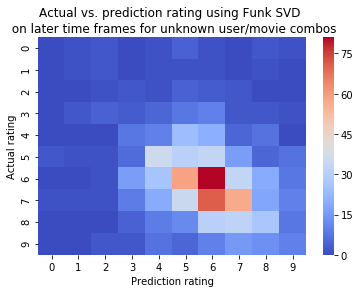

In [8]:
# How well did we do? # Make some plots and calculate some statistics to 
# understand how well this technique is working
sns.heatmap(actual_v_pred,cmap='coolwarm');
plt.title('Actual vs. prediction rating using Funk SVD \n on later time frames for unknown user/movie combos')
plt.xlabel('Prediction rating')
plt.ylabel('Actual rating')

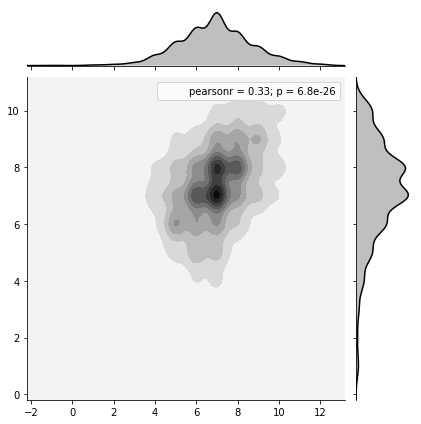

In [9]:
sns.jointplot(np.array(preds), np.array(acts), kind="kde", color="k")

C:\Users\niava\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


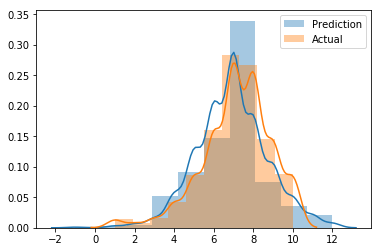

In [10]:
sns.distplot(preds, bins=10)   # what is the meaning of negative rating , why? to do with it? assign to 1, also 12? assign to 10
sns.distplot(acts, bins=10)   
plt.legend(['Prediction', 'Actual'])

In [11]:
print(np.array(preds).min(),np.array(preds).max())  # why? should we truncate?

-1 12


In [12]:
print(np.array(acts).min(),np.array(acts).max())

1 10


`2.` We didn't do so bad on making those predictions!  But, how many user-movie pairs were we unable to make predictions for?  Use the cell below to answer this question.

In [13]:
val_df.shape

(2000, 23)

In [14]:
print('not rated', int((1-perc_rated/100)*val_df.shape[0]))
print('rated', int((perc_rated/100)*val_df.shape[0]))

not rated 1041
rated 959


### Content Based For New Movies

If all of the above went well, you will notice we still have work to do!  We need to bring in a few things we picked up from the last lesson to use for those new users and movies.  Below is the code used to make the content based recommendations, which found movies that were similar to one another.  This was from **5_Content_Based_Recommendations** in the previous lesson.

The below function **find_similar_movies** will provide similar movies to any movie based only on content.  

Run the cell below to gain access to the content based similarity functions.

In [15]:
# Subset so movie_content is only using the dummy variables for each genre and the 3 century based year dummy columns
movie_content = np.array(movies.iloc[:,4:])

# Take the dot product to obtain a movie x movie matrix of similarities
dot_prod_movies = movie_content.dot(np.transpose(movie_content))


def find_similar_movies(movie_id):
    '''
    INPUT
    movie_id - a movie_id 
    OUTPUT
    similar_movies - an array of the most similar movies by title
    '''
    # find the row of each movie id
#     movie_idx = np.where(movies['movie_id'] == movie_id)[0][0]
    
#     # find the most similar movie indices - to start I said they need to be the same for all content
#     similar_idxs = np.where(dot_prod_movies[movie_idx] == np.max(dot_prod_movies[movie_idx]))[0]
    
#     # pull the movie titles based on the indices
#     similar_movies = np.array(movies.iloc[similar_idxs, ]['movie'])

    movie_ids_list = movies.movie_id.values
    dot_prod_movies_df = pd.DataFrame(dot_prod_movies, columns=movie_ids_list, index=movie_ids_list)
    # get similarity from maxx
    tmp = dot_prod_movies_df.loc[movie_id].sort_values(ascending=False)
    # maximum correlation exclusing itself
    max_sim = tmp[tmp.index!=movie_id].max()
    arr = (tmp==max_sim)
    movie_id_list = np.array(arr[arr ==True].index)
    similar_max = np.setdiff1d(movie_id_list,[movie_id],assume_unique=True) # drop itself
    # get similarity from rest        
    arr = ((tmp>max_sim/2.0) & (tmp!=max_sim))
    movie_id_list = np.array(arr[arr ==True].index)
    # take the overlap from max list
    similar_other = np.setdiff1d(movie_id_list,similar_max,assume_unique=True)
    similar_other = np.setdiff1d(np.setdiff1d, [movie_id], assume_unique=True)
    #priority is with max index
    #print(similar_max)
    #print(similar_other)  # issue
    similar_movies = np.append(similar_max, similar_other)
    #similar_max.extend(similar_other) # extend does not work on arrays
    #similar_movies = similar_max
        
    return similar_movies
    
    
def get_movie_names(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    movie_lst = list(movies[movies['movie_id'].isin(movie_ids)]['movie'])
   
    return movie_lst

### Rank Based For New Users

From the above two code cells:
- We have a way to make recommendations for movie-user pairs that have ratings in any part of our user-movie matrix at least one rating, no rows or columns are completely NaN **(Funk SVD)**.
- We also have a way to make ratings for movies that have never received a rating using movie similarities **(content-based, base on categories/year)**.

In this last part here, we need a way to make recommendations to new users.  For this, our functions from **2_Most_Popular_Recommendations** in Lesson 1 will come in handy.  Run the cell below to have these functions available.

Run the cell below to gain access to the rank based functions.

In [16]:
def create_ranked_df(movies, reviews):
        '''
        INPUT
        movies - the movies dataframe
        reviews - the reviews dataframe
        
        OUTPUT
        ranked_movies - a dataframe with movies that are sorted by highest avg rating, more reviews, 
                        then time, and must have more than 4 ratings
        '''
        
        # Pull the average ratings and number of ratings for each movie
        movie_ratings = reviews.groupby('movie_id')['rating']
        avg_ratings = movie_ratings.mean()
        num_ratings = movie_ratings.count()
        last_rating = pd.DataFrame(reviews.groupby('movie_id').max()['date'])
        last_rating.columns = ['last_rating']

        # Add Dates
        rating_count_df = pd.DataFrame({'avg_rating': avg_ratings, 'num_ratings': num_ratings})
        rating_count_df = rating_count_df.join(last_rating)

        # merge with the movies dataset
        movie_recs = movies.set_index('movie_id').join(rating_count_df)

        # sort by top avg rating and number of ratings
        ranked_movies = movie_recs.sort_values(['avg_rating', 'num_ratings', 'last_rating'], ascending=False)

        # for edge cases - subset the movie list to those with only 5 or more reviews
        ranked_movies = ranked_movies[ranked_movies['num_ratings'] > 4]
        
        return ranked_movies
    

def popular_recommendations(user_id, n_top, ranked_movies):
    '''
    INPUT:
    user_id - the user_id (str) of the individual you are making recommendations for
    n_top - an integer of the number recommendations you want back
    ranked_movies - a pandas dataframe of the already ranked movies based on avg rating, count, and time

    OUTPUT:
    top_movies - a list of the n_top recommended movies by movie title in order best to worst
    '''

    top_movies_names = list(ranked_movies['movie'][:n_top])
    #print(ranked_movies['avg_rating'].values[:n_top])
    top_movies_ids = list(ranked_movies.reset_index()['movie_id'][:n_top])
    
    return top_movies_ids, top_movies_names 
        

### Now For Your Task

The above cells set up everything we need to use to make predictions.  Your task is to write a function, which uses the above information as necessary to provide recommendations for every user in the **val_df** dataframe.  There isn't one right way to do this, but using a blend between the three could be your best bet.  

You can see the blended approach I used in the video on the next page, but feel free to be creative with your solution!

`3.` Use the function below along with the document strings to assist with completing the task for this notebook.  

In [17]:
train_df.head(3)

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
498923,37287,2171847,6,1362062307,2013-02-28 14:38:27,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
442554,33140,444778,8,1362062624,2013-02-28 14:43:44,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
81920,6338,1411238,6,1362062838,2013-02-28 14:47:18,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [18]:
x =train_data_df.loc[8]
np.array(x[~train_data_df.loc[8].isnull()].index)

array([385002], dtype=int64)

In [29]:
def make_recommendations(_id, _id_type='movie', train_data=train_data_df, 
                         train_df=train_df, movies=movies, rec_num=5, user_mat=user_mat, movie_mat=movie_mat):
    '''
    INPUT:
    _id - either a user or movie id (int)
    _id_type - "movie" or "user" (str)
    train_data - dataframe of data as user-movie matrix
    train_df - dataframe of training data reviews
    movies - movies df
    rec_num - number of recommendations to return (int)
    user_mat - the U matrix of matrix factorization
    movie_mat - the V matrix of matrix factorization
    
    OUTPUT:
    rec_ids - (array) a list or numpy array of recommended movies by id                  
    rec_names - (array) a list or numpy array of recommended movies by name
    '''
    rec_ids = []
    rec_names = []
    overall = []
    tmp_movie_id = []
    tmp_pred_id = []
    # based on movie--------------
    if(_id_type=='movie'):
        #print('Movie new/exists')
        # do content base get top similar movies if movie new, if movie not new can do item base with correlation with all pair of movie but not here
        rec_ids = find_similar_movies(_id)[0:rec_num]  # adding max criteria priority then the rest some 
        rec_names = get_movie_names(rec_ids)        # add randomness in pulling too
        
    # based on user--------------
    if(_id_type=='user'):
        user_ids_series = np.array(train_data_df.index)
        movie_ids_series = np.array(train_data_df.columns)    
        
        if(_id in user_ids_series): # user id already in training user/matrix data
            #print('User exists')
            predict_array = []
            x =train_data_df.loc[_id]
            user_seen_movie = np.array(x[~train_data_df.loc[_id].isnull()].index)
            # remove movies if user already seen it
            user_unseen_movie = np.setdiff1d(movie_ids_series, user_seen_movie)
            for movie in user_unseen_movie:
                prediction = int(np.round(predict_rating(user_mat, movie_mat, _id, movie),0))
                if(prediction>=7):
                    tmp_movie_id.append(movie) 
                    tmp_pred_id.append(prediction)

            idx = np.argsort(np.array(tmp_pred_id))[::-1]
            tmp_pred_id = np.array(tmp_pred_id)
            tmp_movie_id = np.array(tmp_movie_id)
            rec_ids = tmp_movie_id[idx]
            rec_ids = rec_ids[0:rec_num] # can do random pick of high rated count =rec_num for novelty/surprise
            rec_names = get_movie_names(rec_ids)
            
        if(_id not in user_ids_series):  # user not in the training user/matrix data 
            #print('User new')
            ranked_movies = create_ranked_df(movies, train_df)
            rec_ids, rec_names = popular_recommendations(_id, rec_num, ranked_movies) # can do some randomness here too get 2*rec_num then pick randomly
    #print(overall)
    return list(rec_ids), rec_names

In [30]:
make_recommendations(2215, 'user')

([1024648], ['Argo (2012)'])

In [20]:
movies[movies['movie_id']==2171847]['date'].values[0]

2012

In [21]:
make_recommendations(48, 'user')

([92965, 54215, 775489, 1205489, 903624],
 ['Psycho (1960)',
  'Empire of the Sun (1987)',
  "L'illusionniste (2010)",
  'The Hobbit: An Unexpected Journey (2012)',
  'Gran Torino (2008)'])

In [22]:
make_recommendations(152, 'user')

([99685, 838283, 169547, 469494, 1205489],
 ['Goodfellas (1990)',
  'Step Brothers (2008)',
  'American Beauty (1999)',
  'There Will Be Blood (2007)',
  'Gran Torino (2008)'])

In [23]:
make_recommendations(92965, 'movie')

([55233, 51565, 73800, 87553, 37366],
 ['Thirty Seconds Over Tokyo (1944)',
  'Dunkirk (1958)',
  'Ningen no jôken (1961)',
  'O thiasos (1975)',
  'The Killing Fields (1984)'])

In [32]:
make_recommendations(51201, 'user')

([1682180, 468569, 110912, 286244, 111161],
 ['Pulp Fiction (1994)',
  'The Shawshank Redemption (1994)',
  'Les triplettes de Belleville (2003)',
  'The Dark Knight (2008)',
  'Stoker (2013)'])

In [24]:
val_df.head(2)

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
650588,49056,1598822,8,1363308721,2013-03-15 00:52:01,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
650569,49056,289879,9,1363308742,2013-03-15 00:52:22,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [25]:
user_id_list = val_df.user_id.values
dict_rec_name = {}
dict_rec_id = {}
bar = progressbar.ProgressBar()
for user_id in bar(user_id_list):
    dict_rec_id[user_id], dict_rec_name[user_id] = make_recommendations(user_id, 'user')

100% |########################################################################|


In [36]:
val_df.user_id.nunique()

1241

In [35]:
len(dict_rec_name.keys())

1241

In [33]:
count = 0
for key, value in dict_rec_name.items():
    if(count<20):
        print('user_id',key)
        print('movie recommendation', value)
        print('----------------------------')
        print()
        count += 1

user_id 49056
movie recommendation ['Empire of the Sun (1987)', 'Pulp Fiction (1994)', 'Looper (2012)', 'Oz the Great and Powerful (2013)', 'Stoker (2013)']
----------------------------

user_id 28599
movie recommendation ['Empire of the Sun (1987)', 'The Lion King (1994)', 'The Dark Knight (2008)', 'Bad 25 (2012)', 'Paperman (2012)']
----------------------------

user_id 50593
movie recommendation ['Empire of the Sun (1987)', 'The Shawshank Redemption (1994)', 'Life of Pi (2012)', 'The Perks of Being a Wallflower (2012)', 'Shame (2011)']
----------------------------

user_id 29000
movie recommendation ['Blood Diamond (2006)', 'The Hobbit: An Unexpected Journey (2012)', 'Skyfall (2012)', 'Jack the Giant Slayer (2013)', 'Sinister (2012)']
----------------------------

user_id 32541
movie recommendation ['Empire of the Sun (1987)', 'Blood Diamond (2006)', 'Les Misérables (2012)', 'Shame (2011)']
----------------------------

user_id 9779
movie recommendation ['Empire of the Sun (1987)', 

In [280]:
user_id_list
print(len(user_id_list))

2000


In [28]:
get_movie_names(train_df[train_df['user_id']==2215].movie_id.values)

['The Master (2012)']

**Use this cell to discuss your findings.**

In [45]:
bool_unseen = np.isin([1,7,5,8,6], [1,5,6])
print(bool_unseen)
ix = np.where(bool_unseen)
print(ix)

[ True False  True False  True]
(array([0, 2, 4], dtype=int64),)


In [47]:
y=np.array([1,7,5,8,6])
y[bool_unseen]

array([1, 5, 6])

In [83]:
def make_recommendations(_id, _id_type='movie', train_data=train_data_df, 
                         train_df=train_df, movies=movies, rec_num=5, user_mat=user_mat, movie_mat=movie_mat):
    '''
    INPUT:
    _id - either a user or movie id (int)
    _id_type - "movie" or "user" (str)
    train_data - dataframe of data as user-movie matrix
    train_df - dataframe of training data reviews
    movies - movies df
    rec_num - number of recommendations to return (int)
    user_mat - the U matrix of matrix factorization
    movie_mat - the V matrix of matrix factorization
    
    OUTPUT:
    rec_ids - (array) a list or numpy array of recommended movies by id                  
    rec_names - (array) a list or numpy array of recommended movies by name
    '''
    rec_ids = []
    rec_names = []
    overall = []
    tmp_movie_id = []
    tmp_pred_id = []
    # based on movie--------------
    if(_id_type=='movie'):
        #print('Movie new/exists')
        # do content base get top similar movies if movie new, if movie not new can do item base with correlation with all pair of movie but not here
        rec_ids_tmp = find_similar_movies(_id)[0:2*rec_num]  # adding max criteria priority then the rest some 
        # create some surprise
        rec_ids = np.random.choice(rec_ids_tmp, rec_num, replace=False)
        rec_names = get_movie_names(rec_ids)       
        
    # based on user--------------
    if(_id_type=='user'):
        user_ids_series = np.array(train_data_df.index)
        movie_ids_series = np.array(train_data_df.columns)    
        
        if(_id in user_ids_series): # user id already in training user/matrix data
            #print('User exists')
            predict_array = []
            x =train_data_df.loc[_id]
            user_seen_movie = np.array(x[~train_data_df.loc[_id].isnull()].index)
            # remove movies if user already seen it
            user_unseen_movie_id = np.setdiff1d(movie_ids_series, user_seen_movie)
            user_row = np.where(user_ids_series == _id)[0][0]
            
            prediction = np.dot(user_mat[user_row, :], movie_mat)
            
            bool_unseen = np.isin(movie_ids_series, user_unseen_movie_id)
            ix = np.where(bool_unseen)
            prediction = prediction[bool_unseen]
            idx = np.argsort(prediction)[::-1]
            # sorted unseen movies
            user_unseen_movie_id = user_unseen_movie_id[idx]
            # twice as needed
            user_unseen_movie_id = user_unseen_movie_id[0:2*rec_num]
            # create some surprise
            rec_ids = np.random.choice(user_unseen_movie_id, rec_num, replace=False)
            rec_names = get_movie_names(rec_ids)
            
        if(_id not in user_ids_series):  # user not in the training user/matrix data 
            #print('User new')
            ranked_movies = create_ranked_df(movies, train_df)
            # can do some randomness here too get 2*rec_num then pick randomly
            rec_ids_tmp, _ = popular_recommendations(_id, 2*rec_num, ranked_movies) 
            # create some surprise
            rec_ids = np.random.choice(rec_ids_tmp, rec_num, replace=False)
            rec_names = get_movie_names(rec_ids)
            

    return list(rec_ids), rec_names

In [84]:
_id = 2215
movie_id = 1305806
user_ids_series = np.array(train_data_df.index)
movie_ids_series = np.array(train_data_df.columns) 
movie_col = np.where(movie_ids_series == movie_id)[0][0]
user_row = np.where(user_ids_series == _id)[0][0]
    
print(np.dot(user_mat[user_row, :], movie_mat[:,movie_col]))

4.21598414060458


In [107]:
len(movie_ids_series)

2679

In [99]:
make_recommendations(2215, 'user')

([1447480, 2101341, 1659337, 1045658, 1024648],
 ['Argo (2012)',
  'Silver Linings Playbook (2012)',
  'Bones (2010)',
  'The Perks of Being a Wallflower (2012)',
  'Dead Man Down (2013)'])

In [106]:
make_recommendations(48, 'user')

([363163, 92965, 1723811, 1659337, 838283],
 ['Empire of the Sun (1987)',
  'Der Untergang (2004)',
  'Step Brothers (2008)',
  'The Perks of Being a Wallflower (2012)',
  'Shame (2011)'])

In [82]:
user_id_list = val_df.user_id.values
dict_rec_name = {}
dict_rec_id = {}
bar = progressbar.ProgressBar()
for user_id in bar(user_id_list):
    dict_rec_id[user_id], dict_rec_name[user_id] = make_recommendations(user_id, 'user')

[6.38031149 6.7550385  4.39589202 ... 9.20162942 8.9126158  8.10158134]
[11.2213105  11.2026529  11.01819754 ...  2.01593172  1.88450609
  0.4104629 ]
[6.38031149 6.7550385  4.39589202 ... 9.20162942 8.9126158  8.10158134]
[11.2213105  11.2026529  11.01819754 ...  2.01593172  1.88450609
  0.4104629 ]
[6.38031149 6.7550385  4.39589202 ... 9.20162942 8.9126158  8.10158134]
[11.2213105  11.2026529  11.01819754 ...  2.01593172  1.88450609
  0.4104629 ]
[6.38031149 6.7550385  4.39589202 ... 9.20162942 8.9126158  8.10158134]
[11.2213105  11.2026529  11.01819754 ...  2.01593172  1.88450609
  0.4104629 ]
[6.16629616 6.81146435 4.78440014 ... 8.08690294 8.44079288 5.56779222]
[11.28159984 10.36161062 10.34054873 ...  1.81962608  1.50143902
  1.46061687]
[5.54626003 6.62823449 4.0284789  ... 7.33128217 6.77590286 5.8440671 ]
[10.26880468  9.64161068  9.57229706 ...  1.40674845  1.22720783
  0.81544767]
[6.65431154 7.04046554 4.29464686 ... 7.79690583 7.25374023 5.78884794]
[12.13190013 11.901225

KeyboardInterrupt: 

In [54]:
count = 0
for key, value in dict_rec_name.items():
    if(count<20):
        print('user_id',key)
        print('movie recommendation', value)
        print('----------------------------')
        print()
        count += 1

user_id 49056
movie recommendation ['Incendies (2010)', 'Oz the Great and Powerful (2013)', 'Stoker (2013)', 'Bekas (2012)', 'Pitch Perfect (2012)']
----------------------------

user_id 28599
movie recommendation ['Empire of the Sun (1987)', 'Jack the Giant Slayer (2013)', 'Django Unchained (2012)', 'Jagten (2012)', 'Sound City (2013)']
----------------------------

user_id 50593
movie recommendation ['Empire of the Sun (1987)', 'The Shawshank Redemption (1994)', 'Inglourious Basterds (2009)', 'Life of Pi (2012)', 'Incendies (2010)']
----------------------------

user_id 29000
movie recommendation ['Empire of the Sun (1987)', 'Blood Diamond (2006)', 'Skyfall (2012)', 'Sinister (2012)', 'Jagten (2012)']
----------------------------

user_id 32541
movie recommendation ['Pulp Fiction (1994)', 'Blood Diamond (2006)', 'The Fall (2006)', 'Les Misérables (2012)', 'Shame (2011)']
----------------------------

user_id 9779
movie recommendation ['The Curious Case of Benjamin Button (2008)', 'Li